In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Install Libraries

In [4]:
! pip install -U lightning ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Organize Imports

In [7]:
import os
import gc
from pathlib import Path
import requests
import zipfile

In [8]:
import json

In [9]:
from PIL import Image

In [10]:
import matplotlib.pyplot as plt

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [12]:
from torchmetrics.classification import Dice

In [13]:
from torchvision.models import resnet34, resnet
from torchvision.models.detection import mask_rcnn, maskrcnn_resnet50_fpn, maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import OxfordIIITPet, Cityscapes, wrap_dataset_for_transforms_v2
from torchvision.transforms import v2

In [6]:
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [5]:
from ultralytics import YOLO

## Initialize Folders for Model and Data

In [14]:
def makedirs(dir_path: Path):
    dir_path.mkdir(exist_ok=True, parents=True)

In [15]:
DATA = Path('data')
MODELS = Path('models')
unet_path = MODELS / 'unset'
yolo_path = MODELS / 'yolo11'
pets_path = DATA / 'pets'
carparts_path = DATA / 'carparts'
cracks_path = DATA / 'cracks'
packages_path = DATA / 'packages'
makedirs(unet_path)
makedirs(yolo_path)
makedirs(pets_path)

## Initialize Device

In [16]:
def init_device():
    # For the most part I'll try to import functions and classes near
    # where they are used
    # to make it clear where they come from.
    if torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f'Device: {device}')

    return device

In [17]:
device = init_device()
device

Device: cuda


'cuda'

# Section A: UNet Segmentation Training with Pretrained ResNet34 Backbone

In this section we will train a UNet model for semantic segmentation. The encoder uses a pretrained ResNet34 backbone. We will use the Oxford-IIIT Pet dataset (downloaded via TorchVision) and train our UNet model using PyTorch Lightning.

#### Prepare the Model

In [39]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNetResNet34(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = resnet34(weights=resnet.ResNet34_Weights.DEFAULT)
        self.enc0 = nn.Sequential(base.conv1, base.bn1, base.relu)
        self.enc1 = nn.Sequential(base.maxpool, base.layer1)
        self.enc2 = base.layer2
        self.enc3 = base.layer3
        self.enc4 = base.layer4

        self.dec3 = ConvBlock(512+256, 256)
        self.dec2 = ConvBlock(256+128, 128)
        self.dec1 = ConvBlock(128+64, 64)
        self.dec0 = ConvBlock(64+64, 32)
        self.final = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec3 = self.dec3(torch.cat([F.interpolate(enc4, enc3.size()[2:]), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.size()[2:]), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.size()[2:]), enc1], dim=1))
        dec0 = self.dec0(torch.cat([F.interpolate(dec1, enc0.size()[2:]), enc0], dim=1))

        out = self.final(dec0)   # [B, 1, 59, 59]

        # Upsample explicitly to match target (118,118)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

        return out #torch.sigmoid(out)

In [40]:
class LitUNet(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.dice = Dice(num_classes=2, average='micro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        dice_score = self.dice((y_hat>0.5).int(), y.int())
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_dice", dice_score, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        dice_score = self.dice((y_hat>0.5).int(), y.int())
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_dice", dice_score, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        dice_score = self.dice((y_hat>0.5).int(), y.int())
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_dice", dice_score, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        return [optimizer], [scheduler]

#### Initialize Data

In [59]:
class TargetTransform(object):

    def __init__(self):
        super().__init__()

    def forward(self, y):
        return (y - 1).clamp(0, 1).float()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [60]:
class JointTargetTransform(object):

    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        return x, (y - 1).clamp(0, 1).float()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [51]:
workers=4

In [52]:
class JointTransform:
    def __init__(self, base_size, crop_size):
        self.transforms = v2.Compose([
            v2.Resize(base_size),
            v2.RandomHorizontalFlip(p=0.1),
            v2.RandomVerticalFlip(p=0.1),
            v2.RandomRotation(30),
            v2.RandomCrop(crop_size),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomGrayscale(p=0.1),
            v2.ToTensor(),
        ])

    def __call__(self, image, target):
        image = self.transforms(image, target)
        target = v2.ToTensor()(target).float()
        return image, target

In [67]:
# Define outside PetDataModule at the global level
class PetDataModule(pl.LightningDataModule):
    def setup(self, stage=None):
        transforms_img = v2.Compose([
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomGrayscale(p=0.1),
            v2.Resize((118, 118)),
            v2.ToTensor(),
        ])
        transforms_target = v2.Compose([
            v2.Resize((118, 118)),
            v2.PILToTensor(),
            TargetTransform(),
        ])
        joint_transforms = v2.Compose([
            v2.Resize((118, 118)),
            v2.RandomHorizontalFlip(p=0.1),
            v2.RandomVerticalFlip(p=0.1),
            v2.RandomRotation(30),
            v2.RandomCrop(100),
            # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            # v2.RandomGrayscale(p=0.1),
            # v2.ToTensor(),
            v2.PILToTensor(),
            JointTargetTransform(),
        ])
        self.train_ds = OxfordIIITPet(
            root=pets_path,
            split='trainval',
            target_types='segmentation',
            transform=transforms_img,
            target_transform=transforms_target,
            # transforms=joint_transforms,
            download=True
        )
        self.val_ds = OxfordIIITPet(
            root=pets_path,
            split='test',
            target_types='segmentation',
            transform=transforms_img,
            target_transform=transforms_target,
            download=True)
        self.batch_size = 32

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=workers
        )

#### Prepare Checkpoint Callback

In [68]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=unet_path / 'checkpoints/',
    filename='unet-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

#### Setup Training

In [69]:
model = UNetResNet34()

In [70]:
lit_model = LitUNet(model)

In [71]:
data_module = PetDataModule()

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[checkpoint_callback],
    accelerator='auto',
    devices=1,
    precision='16-mixed',
)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


#### Train the Model

In [72]:
trainer.fit(
    lit_model,
    datamodule=data_module
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNetResNet34      | 24.4 M | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | dice    | Dice              | 0      | train
------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.713    Total estimated model params size (MB)
143       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNetResNet34      | 24.4 M | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | dice    | Dice              | 0      | train
------------------------------------------------------
24.4 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [73]:
trainer.save_checkpoint("last_checkpoint_aug.ckpt")

#### Visualize Predicted Masks

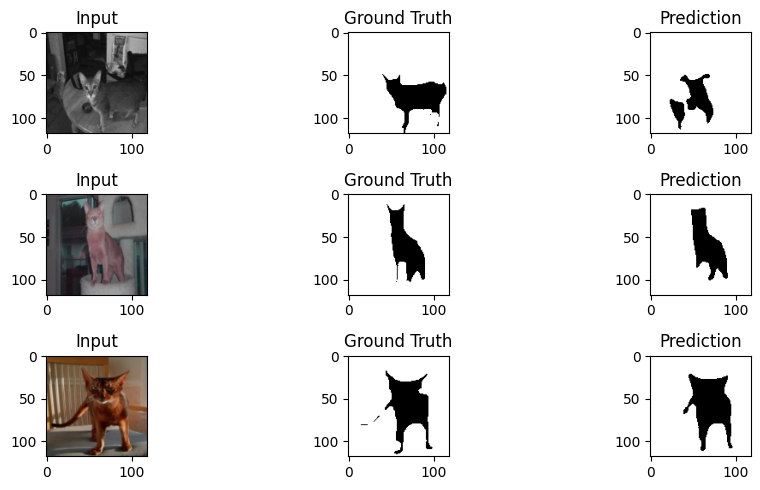

In [74]:
data_module.setup()
x, y = next(iter(data_module.val_dataloader()))
preds = lit_model(x).detach().cpu().numpy()
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.imshow(x[i].permute(1,2,0).cpu().numpy())
    plt.title('Input')
    plt.subplot(3,3,i*3+2)
    plt.imshow(y[i][0], cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(3,3,i*3+3)
    plt.imshow(preds[i][0]>0.5, cmap='gray')
    plt.title('Prediction')
plt.tight_layout()
plt.show()

Check [torchvision model-hub for UNet model](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/) source

In [75]:
gc.collect()

85094

# Section B: Train YOLO11 for Instance Segmentation

In this section we will train a YOLO11 using `ultralytics` models on the different provided datasets for instance segmentation.

In [76]:
model = YOLO("yolo11n-seg.pt")


100%|██████████| 5.90M/5.90M [00:00<00:00, 113MB/s]


#### Download YAML Metadata File

In [77]:
def download_yaml(url: str, dest: Path) -> Path:
    dest.mkdir(exist_ok=True, parents=True)
    file_name = url.split('/')[-1]
    response = requests.get(url)
    file_path = dest / file_name
    if response.status_code == 200:
        with file_path.open('wb') as file:
            file.write(response.content)
        print(f'{file_name} has been downloaded successfully in {file_path}.')
    else:
        print(f'Failed to download file. Status code: {response.status_code}')

    return file_path

#### Prepare Data

In [78]:
url = 'https://github.com/ultralytics/ultralytics/raw/main/ultralytics/cfg/datasets/carparts-seg.yaml'
yaml_path = download_yaml(url, carparts_path)

carparts-seg.yaml has been downloaded successfully in data/carparts/carparts-seg.yaml.


In [80]:
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_runni

#### Train the Model

In [90]:
results = model.train(
    data=yaml_path.name,
    imgsz=118,
    epochs=100,
    batch=128,
    save=True,
    device=device,
    workers=4,
    cache=True,
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=carparts-seg.yaml, epochs=100, time=None, patience=100, batch=128, imgsz=118, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /content/datasets/carparts-seg/train/labels.cache... 3156 images, 116 backgrounds, 0 corrupt: 100%|██████████| 3156/3156 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.1GB RAM): 100%|██████████| 3156/3156 [00:06<00:00, 459.57it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/carparts-seg/valid/labels.cache... 401 images, 12 backgrounds, 0 corrupt: 100%|██████████| 401/401 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 401/401 [00:01<00:00, 207.70it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.001), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.14G      4.307      5.429      5.158      2.892        811        128: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all        401       2042          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.33G      3.777      4.499      5.056      2.599        771        128: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all        401       2042    0.00529    0.00146    0.00273   0.000884    0.00195    0.00125    0.00104   0.000172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.34G      3.109      4.084      4.711       2.18        787        128: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

                   all        401       2042      0.974     0.0167     0.0247    0.00975      0.972     0.0134     0.0179    0.00742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.35G      2.766      3.792      3.999      1.872        834        128: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all        401       2042       0.83     0.0615     0.0459     0.0217      0.829     0.0573     0.0395     0.0162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.36G      2.538      3.569       3.24       1.68        796        128: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all        401       2042      0.674     0.0838     0.0751       0.04      0.673     0.0746      0.069      0.033



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.36G      2.362      3.443      2.779      1.564        834        128: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                   all        401       2042      0.571     0.0996      0.093     0.0513      0.559     0.0917      0.084     0.0417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.36G      2.183      3.308      2.428      1.478        755        128: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]

                   all        401       2042      0.461      0.146      0.127     0.0708      0.449      0.136      0.117     0.0555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.36G      2.078      3.199      2.202       1.41        876        128: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all        401       2042      0.278      0.207      0.147     0.0819       0.27      0.196      0.134     0.0652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.36G      1.988      3.109      2.038      1.372        747        128: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        401       2042      0.358      0.224      0.165     0.0925      0.351      0.204       0.15     0.0731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.37G      1.897      3.043      1.923      1.331        728        128: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

                   all        401       2042      0.322      0.234      0.178     0.0994       0.31      0.212      0.159     0.0766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.38G      1.822       2.95      1.811      1.295        810        128: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        401       2042      0.354       0.24      0.185      0.105      0.337       0.23      0.166     0.0835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.39G       1.78        2.9      1.753      1.271        810        128: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]

                   all        401       2042      0.318      0.283      0.197      0.111      0.309      0.266       0.18     0.0881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100       1.4G      1.752      2.881      1.714      1.261        799        128: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

                   all        401       2042      0.319      0.262        0.2      0.116      0.313      0.244      0.184     0.0923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100       1.4G      1.704      2.816      1.658      1.241        710        128: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]

                   all        401       2042      0.333      0.293      0.209      0.123      0.323      0.262      0.196     0.0984



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       1.4G      1.659      2.761       1.61      1.224        804        128: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]

                   all        401       2042      0.342      0.324      0.217      0.127      0.337      0.305      0.202      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100       1.4G      1.664      2.725      1.591      1.214        726        128: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all        401       2042      0.398      0.314       0.22       0.13      0.389      0.307      0.208      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100       1.4G      1.632      2.709      1.573      1.204        835        128: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        401       2042      0.396      0.336      0.227      0.135       0.39       0.33      0.215      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100       1.4G      1.623      2.695      1.553      1.193        827        128: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                   all        401       2042      0.398      0.337      0.228      0.134      0.397      0.314      0.223      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100       1.4G       1.57      2.631      1.507      1.181        721        128: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        401       2042      0.444      0.339      0.237      0.143      0.441       0.33      0.228      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       1.4G      1.577      2.631      1.491      1.175       1259        128:  84%|████████▍ | 21/25 [00:26<00:05,  1.26s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e64e0136ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
     20/100       1.4G      1.575      2.629      1.488      1.175       1168        128:  88%|████████▊ | 22/25 [00:27<00:03,  1.17s/it]^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e64e0

                   all        401       2042      0.444      0.343      0.241      0.146      0.442      0.331      0.233      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100       1.4G      1.545      2.574      1.461      1.167        755        128: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]

                   all        401       2042      0.446      0.367      0.246      0.148      0.444      0.356      0.235      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100       1.4G      1.533      2.599      1.439       1.16        854        128: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]

                   all        401       2042      0.434      0.361       0.25      0.151      0.432      0.354       0.24      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.4G      1.535       2.57      1.443      1.158        703        128: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all        401       2042      0.468      0.356      0.257      0.156      0.465      0.347      0.251      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100       1.4G      1.507      2.545      1.414      1.147        820        128: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all        401       2042      0.434      0.363      0.265      0.162       0.42      0.356      0.257      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100       1.4G      1.499      2.522      1.399      1.143        777        128: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

                   all        401       2042       0.38      0.376      0.276      0.169      0.384      0.371      0.269      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100       1.4G      1.485      2.507      1.376       1.14        723        128: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]

                   all        401       2042      0.442      0.375      0.279      0.171      0.439      0.371      0.273      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100       1.4G      1.488      2.485      1.376      1.132        769        128: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all        401       2042      0.421      0.357      0.286      0.176      0.412      0.361      0.278      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100       1.4G      1.462      2.455      1.358      1.131        780        128: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all        401       2042      0.396      0.387      0.285      0.176      0.393      0.381      0.277      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100       1.4G       1.46      2.462      1.352      1.126        807        128: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

                   all        401       2042      0.381      0.371       0.29      0.177      0.377      0.366      0.281      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100       1.4G      1.435       2.43      1.332      1.119        804        128: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

                   all        401       2042      0.399       0.39      0.301      0.183      0.395      0.387      0.295      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100       1.4G      1.436      2.415      1.319      1.118        805        128: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]

                   all        401       2042      0.352      0.409      0.297      0.182      0.349      0.397      0.289       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100       1.4G      1.423      2.406      1.302      1.112        824        128: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all        401       2042      0.409      0.383      0.308       0.19      0.452      0.373      0.302      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100       1.4G      1.427        2.4        1.3      1.108        740        128: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all        401       2042      0.437      0.416      0.313       0.19      0.435      0.403      0.308      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100       1.4G      1.401      2.378      1.278      1.103        885        128: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        401       2042      0.346       0.43      0.314      0.191      0.338      0.422      0.305      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       1.4G      1.408      2.369      1.287      1.107        793        128: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

                   all        401       2042      0.409      0.395      0.311      0.193      0.405      0.387      0.307      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100       1.4G      1.389      2.336      1.269      1.102        813        128: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all        401       2042      0.369      0.428      0.317      0.195      0.404      0.422      0.311      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100       1.4G      1.387      2.337      1.254      1.093        801        128: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all        401       2042      0.371      0.431      0.325      0.202      0.424      0.402      0.322      0.168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100       1.4G      1.387      2.322      1.252      1.094        752        128: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]

                   all        401       2042       0.42      0.404      0.323      0.199      0.424      0.397      0.321      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100       1.4G      1.379      2.313      1.241      1.092        782        128: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

                   all        401       2042      0.372      0.444      0.323      0.202      0.416      0.425      0.319       0.17



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100       1.4G       1.38      2.338      1.236      1.098        857        128: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]

                   all        401       2042      0.481      0.365      0.325      0.202      0.479      0.365       0.32      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100       1.4G      1.375      2.309      1.239      1.086        748        128: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all        401       2042      0.371      0.425      0.338       0.21      0.383      0.405      0.331      0.175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100       1.4G      1.351       2.28      1.215      1.085        802        128: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all        401       2042      0.428      0.396      0.336       0.21      0.427      0.396      0.332      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100       1.4G      1.359      2.303      1.226      1.085       1233        128:  40%|████      | 10/25 [00:13<00:20,  1.36s/it]


KeyboardInterrupt: 

In [ ]:
/content/datasets/carparts-seg

In [17]:
images_dir = Path('/content') / 'datasets' / 'carparts-seg' / 'test' / 'images'

In [18]:
image_paths = list(images_dir.glob('*.jpg'))

In [19]:
str(images_dir)

'/content/datasets/carparts-seg/test/images'

In [20]:
image_paths[0]

PosixPath('/content/datasets/carparts-seg/test/images/new_18_png_jpg.rf.43f4e6da2a4b72edb6cdf4ac865d0213.jpg')

In [2]:
results = model(source=str(image_paths[0]), show=True)

NameError: name 'model' is not defined

In [15]:
yolo_model = YOLO('yolo11n.pt')

In [21]:
results = yolo_model(source=str(image_paths[0]), show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/datasets/carparts-seg/test/images/new_18_png_jpg.rf.43f4e6da2a4b72edb6cdf4ac865d0213.jpg: 640x640 1 suitcase, 11.3ms
Speed: 3.7ms preprocess, 11.3ms inference, 159.0ms postprocess per image at shape (1, 3, 640, 640)


In [22]:
img = results[0].plot()

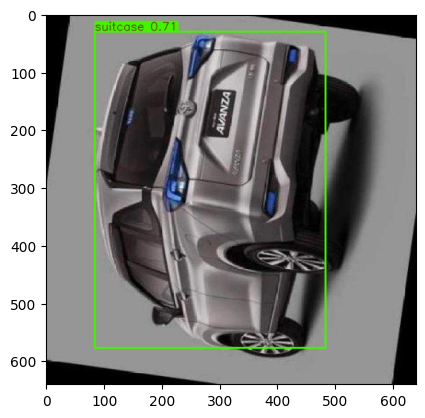

In [23]:
plt.imshow(img)
plt.show()
# plt.close()

In [2]:
idx = 0
results = yolo_model(source=str(image_paths[idx]), show=True)
img = results[0].plot()
plt.imshow(img)
plt.show()
# plt.close()

NameError: name 'yolo_model' is not defined

#### Visualize Prediction

In [81]:
# Predict with the model
results = model(source="https://ultralytics.com/images/bus.jpg", show=True)  # predict on an image

# Access the results
# for result in results:
#     xy = result.masks.xy  # mask in polygon format
#     xyn = result.masks.xyn  # normalized
#     masks = result.masks.data  # mask in matrix format (num_objects x H x W)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()





100%|██████████| 134k/134k [00:00<00:00, 9.78MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 57.1ms
Speed: 17.2ms preprocess, 57.1ms inference, 222.1ms postprocess per image at shape (1, 3, 640, 480)


In [84]:
img = results[0].plot()

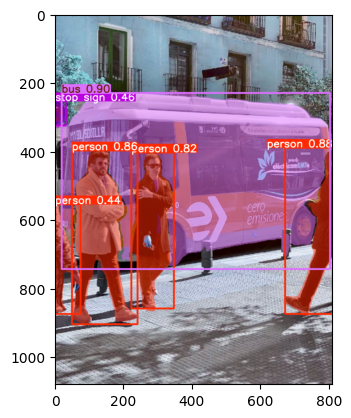

In [85]:
plt.imshow(img)
plt.show()
plt.close()

#### Train on Crack Dataset

In [ ]:
url = 'https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/crack-seg.yaml'
yaml_path = download_yaml(url, cracks_path)

In [ ]:
results = model.train(
    data=yaml_path.name,
    epochs=100,
    imgsz=640,
    device=device,
    workers=11,
)

#### Train on Packages Dataset

In [ ]:
url = 'https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/package-seg.yaml'
yaml_path = download_yaml(url, packages_path)

In [ ]:
results = model.train(
    data=yaml_path.name,
    epochs=100,
    imgsz=640,
    device=device,
    workers=11,
)